# Toxic comments Iteration 2 - Zina Bazarbashi

In [5]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

In [6]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [91]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())
        # this identifies the percentage of the data that is in ANY way toxic = 0.1016 meaning roughly 10% 

    # vectorize Bag of Words from review text; as sparse matrix
#     hv = HashingVectorizer(n_features=2 ** 19, alternate_sign=False)
#     X_hv = hv.fit_transform(toxic_data.comment_text)
#     print("Shape of HashingVectorizer X:")
#     print(X_hv.shape)
     # vectorize Bag of Words from review text; as sparse matrix
    if (not test): # fit_transform()
        hv = HashingVectorizer(n_features=2 ** 20, strip_accents= 'unicode', alternate_sign=False, norm='l2', decode_error='strict')
        X_hv = hv.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(hv)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    else: # transform() 
        X_hv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_hv.shape)
    
    # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    #calculates frequencies then divides it by inverse so it calculates weight
    if (not test):
        transformer = TfidfTransformer()
        X_tfidf = transformer.fit_transform(X_hv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[1].transform(X_hv)
        
    # create additional quantitative features
    # SEE HOW THIS AFFECTS THE DATA BY TRYING IT WITH AND WITHOUT
    # features from Amazon.csv to add to feature set
    toxic_data['word_count'] = toxic_data['comment_text'].str.split(' ').str.len()
    toxic_data['punc_count'] = toxic_data['comment_text'].str.count("\.")

    X_quant_features = toxic_data[["word_count", "punc_count"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(10))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
#     sc = StandardScaler(with_mean=False)
#     X = sc.fit_transform(X_matrix)
#     print(X.shape)
#     if (not test):
#         y = toxic_data['any_toxic']
 
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[2].transform(X_matrix)
        print(X.shape)
    
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
         #the raw shape meaning without the bag of words and hashing vectorizer
        print(X_raw_train.shape) 
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [92]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []


# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='toxiccomments_train.csv', my_random_seed=23)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit & Tune Various Models

### MODEL: SVM, linear

In [93]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(loss='hinge', penalty='elasticnet', alpha=0.00001, max_iter=25000, shuffle=True, average=300, n_iter_no_change=5, class_weight='balanced', learning_rate='optimal' )
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12916, 'TN': 111036, 'FP': 3675, 'FN': 29, 'Accuracy': 0.9709845208999185, 'Precision': 0.7784943644144415, 'Recall': 0.997759752800309, 'desc': 'svm_train'}


### MODEL: Logistic Regression

In [85]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log', penalty='elasticnet', alpha=0.00001,l1_ratio=0.15, max_iter=20000, shuffle=True, average=150, n_iter_no_change=2, class_weight='balanced')
#i added a really low alpha value to increase generalization, and saw that when i added the average the recall increased
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 12945, 'Neg': 114711, 'TP': 12913, 'TN': 110461, 'FP': 4250, 'FN': 32, 'Accuracy': 0.9664567274550354, 'Precision': 0.7523742935384257, 'Recall': 0.9975280030899961, 'desc': 'lgs_train'}


### MODEL: Random Forest Classifier

In [86]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(n_estimators=50, criterion='entropy', max_depth=None, min_samples_split=200, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

KeyboardInterrupt: 

### ROC plot to compare performance of various models and fits

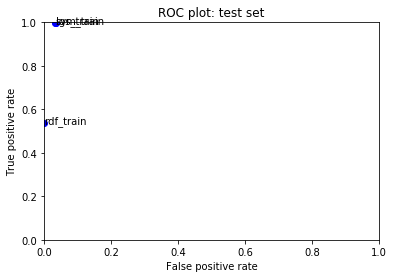

In [87]:
fits = [svm_performance_train, lgs_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

# False Positives

In [88]:
print("Examples of false positives:")

import random, time
lgs_predictions = lgs.predict(X_train)

for i in range(0, len(lgs_predictions)):  #when uploading to github, make the length shorter than the entire list
    if (lgs_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 10% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')

#It may be that its using all caps and profuse use of punctuation is being learned as toxic
#i would like to re-iterate that some of the trained data is mis-labelled or bias!

Examples of false positives:
80
"

he swears all over the place and gets no warnings, my brother got banned for calling someone a ""troll""
wikipedia biased!! (((((((((((((((((((((((((((((((((((((not that i care i quit this nasty place )"
* * * * * * * * * 
361
Edwin 

it says in the character description everyone is cold blooded but Edwin, i am pretty sure thats wrong, can someone explain this to me?
* * * * * * * * * 
1190
You will now be Blocked.
* * * * * * * * * 
1641
I STILL GIVE UP . Get a better life you two.
* * * * * * * * * 
2206
"

Lordkazan, I am currently looking for suitable citations. But still, I feel my original point was intentionally overlooked. You see, recently, I edited a German article concerning a Neonazi brand name (de:Consdaple). In that article, I inserted totally ""biased"" ridiculing phrases, because I felt that in Germany, it is always better to decidedly distance yourself from Nazism (and because I am rather convinced of my eloquence in German, although 

20747
Right, with the exception of Masem, everyone agree's it should be mentioned. The sentence should not include technical info. My draft - On December 2015, Steam's content delivery network was misconfigured in response to a DDoS attack, causing 34,000 users' personal information to be exposed.
* * * * * * * * * 
20945
I would agree too if you could remove that word. It only makes him angrier, as you can see with his latest sockpuppet's user name. Cheers,
* * * * * * * * * 
21903
I don't really know for sure. I've talked to  on Wikipedia's IRC. He says they violate WP:FUC, but I'm not sure how.
* * * * * * * * * 
22960
These are facts, if you guys continue to delete this then you are just being censors. People want the TRUTH.
* * * * * * * * * 
23878
"
 ""You heard""? Did a little bird tell you?"
* * * * * * * * * 
24572
Deleteing my writing 

I spent a lot of time writing the article in Rajbeer Singh.  Who gives you the write to just come and delete all my writing as you please?  c

41807
Why have you never blocked the racist vandalizing IPs?!?!?!?!?! Do I have the right to vandalize your talkpage and call you a Jew? Why do you give that right to IPs?!?!?!
* * * * * * * * * 
42899
Thanks for your reply:
 
1- Who has raised the NPOV objection that you have dated?

2- What are the basis as they would have to state a reason, otherwise it is illegal?

3- The warnings on my page have all been by GlassFet. I maintained from the beginning that he was a sockpuppet of Ekajati who was banned and had many other illegal names too. Finally this was proven and he was banned. Someone, I do not know who, probably a bot or an admin, had set his warnings invisible. They are now again visible after your interaction. I consider them an honor. I will monitor for his presence in any way possible vigilantly in future. Are you in any form in contact with that person or his cult of English Aro which is dismissed by Tibetan lamas and considered anti-Buddhist? 

4- If no comment on the obje

63062
" Just look at this total self-centered idiot posing in a photo booth - ""I'm a marine, a hard guy, and an intellectual. I can juggle plates on my Johnson, I can do anything."" Total sad guy. How self obsessed can you get? "
* * * * * * * * * 
64328
Did you play Double Agent or Conviction? 2001:558:6026:97:44AF:E2BF:9B1E:3DD9
* * * * * * * * * 
64613
. i.e. I won't give up
* * * * * * * * * 
64734
Age 

You might want to reconsider advertising your age.  Not many people are going to take seriously anything some 14-year-old, snot-nosed, wet-behind-the-ears punk kid has to say.
* * * * * * * * * 
65391
"

 Requested move 

Hello J. 'mach' wust,I added my ""support"" vote to the move to Low Germanic languages. It was late in the evening when I voted and I had already made up my mind from the entry at WP:RM, so I didn't take much notice. Anyway, no harm done.  "
* * * * * * * * * 
65603
Merger Section 

The section on the merger with Sleepy Hollow seems to me, to be promoting the mer

95186
Dcandeto please cite sources to attest to the notability of the writer.  If not, it should be held up to the same standards as other works such as mine (which I believe was a lot more notable than this) and deleted.
* * * * * * * * * 
96271
Can't you people take a joke every once and a while For God's Sakes
* * * * * * * * * 
97231
Blocked 3RR

Do not erase, do not erase, do not remove, do not remove!!!

   
  
 

Polish friends

Last warning! Blocked 3RR

Do not erase, do not erase, do not remove, do not remove!!!

 

Polish friends
* * * * * * * * * 
97397
|| needs-infobox = yes| needs-persondata = yes | needs-photo = yes
* * * * * * * * * 
97785
"

Why should I ""assume good faith"" from someone adding anti-Semitic lies to an article? Your obvious ignorance on the subject is not an excuse."
* * * * * * * * * 
98638
HAHAHAHAHAHA I laugh at the irony of your statement, considering that the Climate Change, Global warming socialists who hijacked Wikipedia want the general public t

126044
"

 Gregalton, You're Still A Douchebag, Signed... 

I'm not an editor, so I really don't have a problem calling you a douchebag. The fact that the article considers anyone who criticizes the practice of FRB as non-mainstream raised the flag in my mind, that is, made me check the discussion page. You've done more to bias the article than these supposed ""conspiracy"" people probably did. At any rate, fuck Wikipedia, and fuck Gregalton; I wait for the day when Knol has a good article under the same title (and it's written by one of these ""non-mainstream"" economists the article talks about).

Delete this again, gregalton... you're dealing with a loser with more time than even you, so don't try... 

besides, it's not like I'm editing the main page... I was looking for information and you screwed me out of it."
* * * * * * * * * 
127238
Wow, that is a really classy insult! Nothing witty to say so you resort to petty insults?
* * * * * * * * * 
127429
PS2: Why pollute Google & the 

# Look at performance on the test set

In [94]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2606, 'TN': 25857, 'FP': 2778, 'FN': 674, 'Accuracy': 0.8918376938743537, 'Precision': 0.4840267459138187, 'Recall': 0.7945121951219513, 'desc': 'svm_test'}


In [90]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 2572, 'TN': 25736, 'FP': 2899, 'FN': 708, 'Accuracy': 0.8869810433965221, 'Precision': 0.47011515262292086, 'Recall': 0.7841463414634147, 'desc': 'lgs_test'}


In [80]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3280, 'Neg': 28635, 'TP': 923, 'TN': 28628, 'FP': 7, 'FN': 2357, 'Accuracy': 0.9259282469058436, 'Precision': 0.9924731182795699, 'Recall': 0.2814024390243902, 'desc': 'rdf_test'}


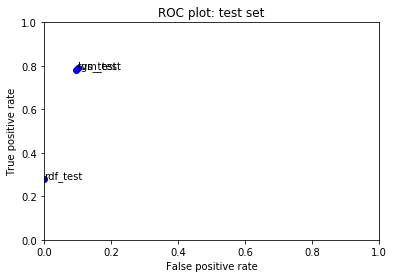

In [81]:
#PLOT

fits = [svm_performance_test, lgs_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [23]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='toxiccomments_test.csv', my_random_seed=23, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 524288)
Look at a few rows of the new quantitative features: 
   word_count  punc_count
0          72          10
1          13           1
2          16           0
3          38           3
4           7           1
5          16           2
6          31           4
7           6       

In [ ]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = lgs.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

#I had a prediction mean that was .25 before, not sure what changed the result!

In [ ]:
raw_data.head()

In [ ]:
my_submission.head()

In [ ]:
my_submission.shape

In [ ]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('toxiccomments_submission2_zina.csv', index=False)